# Intercomparison

**Author:** Hannah Kerner, Ivan Zvonkov

**Last updated:** February 6, 2024

**Description:** Runs intercomparison for Rwanda 2019

## 1. Setup

In [1]:
#earthengine authenticate

In [2]:
import ee
import geemap
import sys
import pandas as pd
import geopandas as gpd

ee.Initialize()

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL, get_ensemble_area
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

## 2. Read in evaluation set

In [3]:
country = "Rwanda"
country_code = TEST_CODE[country]
dataset_path = "../" + TEST_COUNTRIES[country]

In [20]:
df = pd.read_csv(dataset_path)[["lat", "lon", "class_probability", "subset"]]
#df = df[(df["class_probability"] != 0.5)].copy()
df = df[(df["class_probability"] == 1) | (df["class_probability"] == 0)].copy()
# use only test data because validation points used for harvest-dev map
df = df[df["subset"] == "testing"].copy()
df[CLASS_COL] = (df["class_probability"] > 0.5).astype(int)
df[COUNTRY_COL] = country

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

/Users/hkerner/anaconda3/envs/landcover-mapping/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [21]:
gdf

,lat,lon,class_probability,subset,binary,country,geometry
18,-2.286221,30.592638,0.0,testing,0,Rwanda,POINT (30.59264 -2.28622)
22,-2.180136,29.697418,1.0,testing,1,Rwanda,POINT (29.69742 -2.18014)
44,-1.496526,30.640510,0.0,testing,0,Rwanda,POINT (30.64051 -1.49653)
59,-1.393807,30.638713,0.0,testing,0,Rwanda,POINT (30.63871 -1.39381)
68,-2.548167,29.226861,0.0,testing,0,Rwanda,POINT (29.22686 -2.54817)
...,...,...,...,...,...,...,...
1131,-1.604449,30.172468,1.0,testing,1,Rwanda,POINT (30.17247 -1.60445)
1153,-2.020816,30.164742,0.0,testing,0,Rwanda,POINT (30.16474 -2.02082)
1162,-1.549411,29.428591,0.0,testing,0,Rwanda,POINT (29.42859 -1.54941)
1182,-1.713084,30.273602,1.0,testing,1,Rwanda,POINT (30.27360 -1.71308)


## 3. Run intercomparison

In [22]:
TARGETS = {k:v for k,v in TARGETS.items()}

In [23]:
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")
    gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

[Rwanda] sampling copernicus...
[Rwanda] sampling worldcover-v100...
[Rwanda] sampling worldcover-v200...
[Rwanda] sampling worldcereal-v100...
[Rwanda] sampling glad...
[Rwanda] sampling asap...
[Rwanda] sampling dynamicworld...
[Rwanda] sampling gfsad-gcep...
[Rwanda] sampling gfsad-lgrip...
[Rwanda] sampling digital-earth-africa...
[Rwanda] sampling esa-cci-africa...
[Rwanda] sampling globcover-v23...
[Rwanda] sampling globcover-v22...
[Rwanda] sampling esri-lulc...
[Rwanda] sampling nabil-etal-2021...
[Rwanda] sampling harvest-dev...


In [24]:
a_j = {}
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] calculating pixel area for " + cropmap.title + "...")
    a_j[cropmap.title] = cropmap.compute_map_area(country).copy()

[Rwanda] calculating pixel area for copernicus...
[Rwanda] calculating pixel area for worldcover-v100...
[Rwanda] calculating pixel area for worldcover-v200...
[Rwanda] calculating pixel area for worldcereal-v100...
[Rwanda] calculating pixel area for glad...
[Rwanda] calculating pixel area for asap...
[Rwanda] calculating pixel area for dynamicworld...
[Rwanda] calculating pixel area for gfsad-gcep...
[Rwanda] calculating pixel area for gfsad-lgrip...
[Rwanda] calculating pixel area for digital-earth-africa...
[Rwanda] calculating pixel area for esa-cci-africa...
[Rwanda] calculating pixel area for globcover-v23...
[Rwanda] calculating pixel area for globcover-v22...
[Rwanda] calculating pixel area for esri-lulc...
[Rwanda] calculating pixel area for nabil-etal-2021...
[Rwanda] calculating pixel area for harvest-dev...


In [25]:
comparisons = []
for cropmap in TARGETS.keys():
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap], a_j[cropmap], area_weighted=True)
    comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])

# Add ensemble
ensemble_maps = ["glad", "worldcover-v100", "esri-lulc", "digital-earth-africa",
                 "dynamicworld", "esa-cci-africa", "gfsad-gcep", "nabil-etal-2021",
                 "copernicus", "globcover-v23", "asap"] # Should be odd number
print(f"Ensemble maps: {ensemble_maps}")
ensemble = gdf[ensemble_maps].mode(axis='columns')
a_j['ensemble-subset'] = get_ensemble_area(country, [TARGETS[name] for name in ensemble_maps])
comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble, a_j['ensemble-subset'], area_weighted=True)
comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])
results

Ensemble maps: ['glad', 'worldcover-v100', 'esri-lulc', 'digital-earth-africa', 'dynamicworld', 'esa-cci-africa', 'gfsad-gcep', 'nabil-etal-2021', 'copernicus', 'globcover-v23', 'asap']


,country,crop_f1,std_crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,noncrop_recall_pa,std_noncrop_pa,crop_precision_ua,...,crop_support,noncrop_support,tn,fp,fn,tp,tn_area,fp_area,fn_area,tp_area
dataset,,,,,,,,,,,,,,,,,,,,,
copernicus,Rwanda,0.75,0.18,0.77,0.04,0.78,0.05,0.76,0.05,0.73,...,43,64,53,11,13,30,0.42,0.13,0.10,0.35
worldcover-v100,Rwanda,0.82,0.15,0.87,0.03,0.74,0.06,0.95,0.02,0.91,...,43,64,61,3,11,32,0.58,0.03,0.10,0.29
worldcover-v200,Rwanda,0.78,0.16,0.84,0.04,0.69,0.05,0.95,0.03,0.91,...,43,64,61,3,14,29,0.56,0.03,0.13,0.29
worldcereal-v100,Rwanda,0.54,0.07,0.74,0.04,0.37,0.04,1.00,0.00,1.00,...,43,64,64,0,28,15,0.59,0.00,0.26,0.15
glad,Rwanda,0.72,0.18,0.77,0.04,0.64,0.05,0.89,0.05,0.84,...,43,64,60,4,22,21,0.47,0.06,0.17,0.30
asap,Rwanda,0.74,0.16,0.71,0.05,0.88,0.04,0.58,0.05,0.64,...,43,64,44,20,8,35,0.31,0.23,0.06,0.40
dynamicworld,Rwanda,0.42,0.06,0.71,0.04,0.27,0.03,1.00,0.00,1.00,...,43,64,64,0,31,12,0.60,0.00,0.29,0.11
gfsad-gcep,Rwanda,0.73,0.18,0.74,0.04,0.79,0.05,0.69,0.05,0.67,...,43,64,49,15,12,31,0.38,0.17,0.09,0.35
gfsad-lgrip,Rwanda,0.71,0.18,0.72,0.04,0.77,0.05,0.67,0.05,0.65,...,43,64,48,16,13,30,0.37,0.18,0.10,0.34


In [26]:
results.to_csv('/Users/hkerner/Documents/Publications/Crop Mask Intercomparison/map-notebook-outputs/rwanda-2019-results.csv')

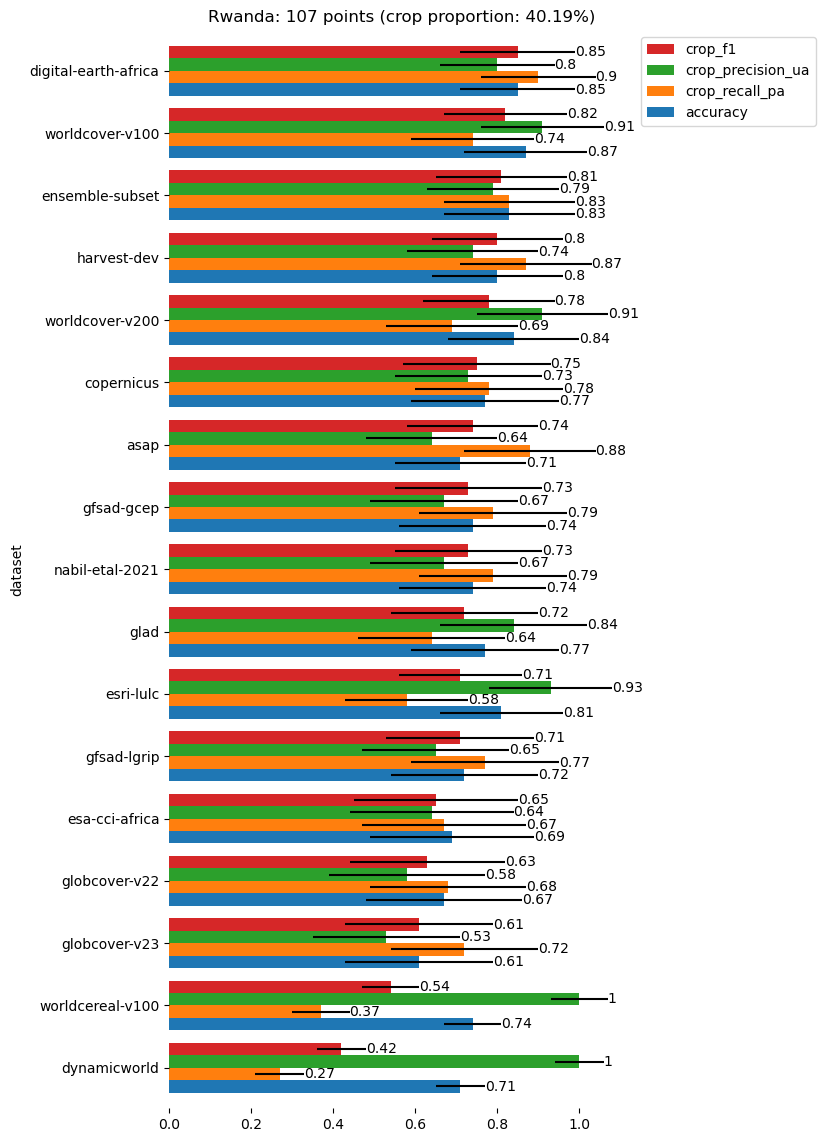

In [27]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"], 
    xerr="std_crop_f1",
    kind="barh", 
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

## 4. Visualize best available map

In [28]:
# Run this cell to view and export map
print("To view and export map copy and paste the text below the dashed line into GEE\n" + "-"*100)
best_dataset = results["crop_f1"].idxmax()
if best_dataset in TARGETS:
    print(TARGETS[best_dataset].ee_script(country))
else:
    image_var_names = [TARGETS[d].title_safe for d in ensemble_maps]
    for i, dataset in enumerate(ensemble_maps):
        print(TARGETS[dataset].ee_script(country, include_prefix=(i == 0), include_export=False))
        print("\n")
    print(f"var ensemble = ee.ImageCollection.fromImages([{', '.join(image_var_names)}]).mode()")
    print(f"Map.addLayer(ensemble, classVis, 'Cropland from ensemble');")
    print(f"""
Export.image.toCloudStorage({{
    image: ensemble,
    description: "{country}_ensemble_{'_'.join(image_var_names)}",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: "{country}_ensemble_{'_'.join(image_var_names)}",
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e10,
    skipEmptyTiles: true
}});""")

To view and export map copy and paste the text below the dashed line into GEE
----------------------------------------------------------------------------------------------------

var palettes = require('users/gena/packages:palettes');
var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}
var aoi = ee.FeatureCollection("FAO/GAUL/2015/level0")
    .filter(ee.Filter.eq('ADM0_NAME', 'Rwanda'));
Map.centerObject(aoi, 7);

var digital_earth_africa = ee.ImageCollection([ee.Image(0)
            .where(ee.ImageCollection("projects/sat-io/open-datasets/DEAF/CROPLAND-EXTENT/filtered")
            .mosaic()
            .eq(1), 1)]
        ).filterBounds(aoi).mosaic().clip(aoi);
digital_earth_africa = digital_earth_africa.eq(1).rename('crop')
Map.addLayer(digital_earth_africa, classVis, 'Cropland from digital-earth-africa');
Export.image.toCloudStorage({
    image: digital_earth_africa,
    description: "Rwanda_digital_earth_africa",
    bucket: 'crop-mask-preds-merged',
    fileNamePref